In [2]:
import sklearn
import sklearn.datasets
import sklearn.neighbors
import sklearn.tree
import fairlearn
import numpy as np
from fairlearn.metrics import MetricFrame
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from fairlearn.metrics import false_negative_rate
from fairlearn.metrics import false_negative_rate
from fairlearn.metrics import false_positive_rate
from fairlearn.metrics import selection_rate
from fairlearn.metrics import count
from fairlearn.reductions import DemographicParity, ExponentiatedGradient
import pandas as pd
import matplotlib.pyplot as plt
from fairlearn.datasets import fetch_adult

In [3]:
data = fetch_adult(as_frame=True)

modelKnn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)

In [4]:
modelTree = sklearn.tree.DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)

In [5]:
data = fetch_adult(as_frame=True)
X = pd.get_dummies(data.data)
y_true = (data.target == '>50K') * 1
sex = data.data['sex']
sex.value_counts()

modelTree.fit(X, y_true)

y_pred = modelTree.predict(X)
mf = MetricFrame(metrics=accuracy_score, y_true=y_true, y_pred=y_pred, sensitive_features=sex)

In [46]:
mf.overall

np.float64(0.8443552680070431)

In [47]:
mf.by_group

sex
Female    0.925148
Male      0.804288
Name: accuracy_score, dtype: float64

In [48]:
y_true

0        0
1        0
2        1
3        1
4        0
        ..
48837    0
48838    1
48839    0
48840    0
48841    1
Name: class, Length: 48842, dtype: int64

In [49]:
y_pred

array([0, 0, 0, ..., 0, 0, 1])

array([[<Axes: title={'center': 'accuracy'}, xlabel='sex'>,
        <Axes: title={'center': 'precision'}, xlabel='sex'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='sex'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='sex'>,
        <Axes: title={'center': 'selection rate'}, xlabel='sex'>,
        <Axes: title={'center': 'count'}, xlabel='sex'>],
       [<Axes: xlabel='sex'>, <Axes: xlabel='sex'>, <Axes: xlabel='sex'>]],
      dtype=object)

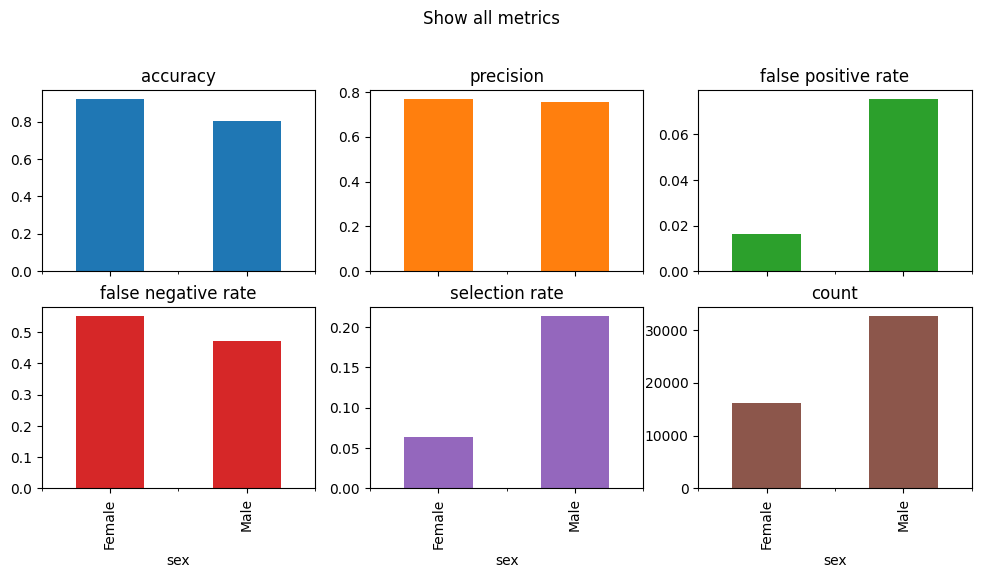

In [50]:
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
    "count": count,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_true, y_pred=y_pred, sensitive_features=sex
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)


In [51]:
modelKnn.fit(X, y_true)

y_pred = modelKnn.predict(X)
mf = MetricFrame(metrics=accuracy_score, y_true=y_true, y_pred=y_pred, sensitive_features=sex)

array([[<Axes: title={'center': 'accuracy'}, xlabel='sex'>,
        <Axes: title={'center': 'precision'}, xlabel='sex'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='sex'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='sex'>,
        <Axes: title={'center': 'selection rate'}, xlabel='sex'>,
        <Axes: title={'center': 'count'}, xlabel='sex'>],
       [<Axes: xlabel='sex'>, <Axes: xlabel='sex'>, <Axes: xlabel='sex'>]],
      dtype=object)

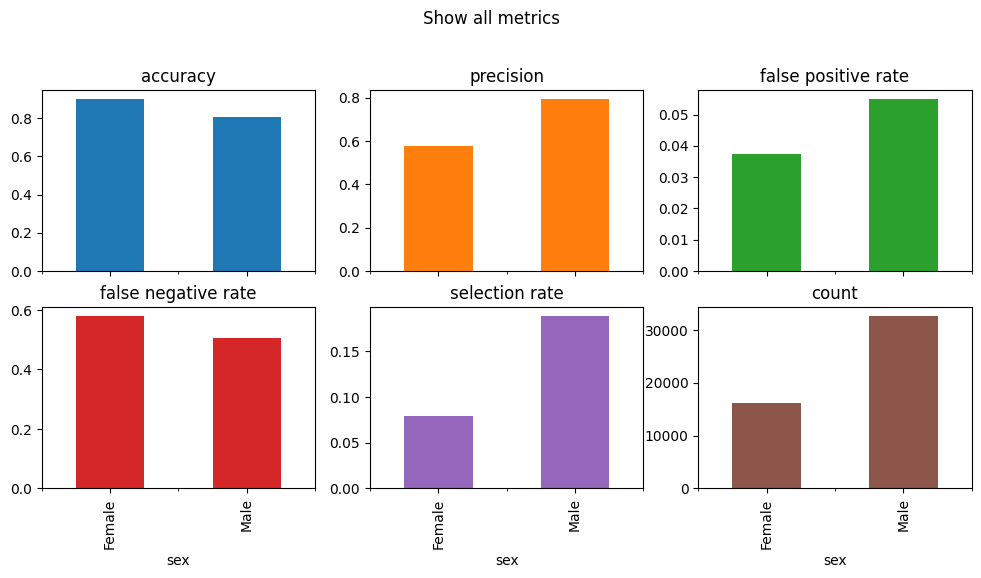

In [52]:
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
    "count": count,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_true, y_pred=y_pred, sensitive_features=sex
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)


In [6]:

np.random.seed(0)  # set seed for consistent results with ExponentiatedGradient

constraint = DemographicParity()
classifier = sklearn.tree.DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
mitigator = ExponentiatedGradient(classifier, constraint)
mitigator.fit(X, y_true, sensitive_features=sex)

c:\Users\migan\Desktop\2024-2025\MS\.venv\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
c:\Users\migan\Desktop\2024-2025\MS\.venv\Lib\sit

ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.DemographicParity object at 0x000001C373F882D0>,
                      estimator=DecisionTreeClassifier(max_depth=4,
                                                       min_samples_leaf=10),
                      nu=np.float64(0.0008201769357601916))

In [10]:
y_pred = mitigator.predict(X)

array([[<Axes: title={'center': 'accuracy'}, xlabel='sex'>,
        <Axes: title={'center': 'precision'}, xlabel='sex'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='sex'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='sex'>,
        <Axes: title={'center': 'selection rate'}, xlabel='sex'>,
        <Axes: title={'center': 'count'}, xlabel='sex'>],
       [<Axes: xlabel='sex'>, <Axes: xlabel='sex'>, <Axes: xlabel='sex'>]],
      dtype=object)

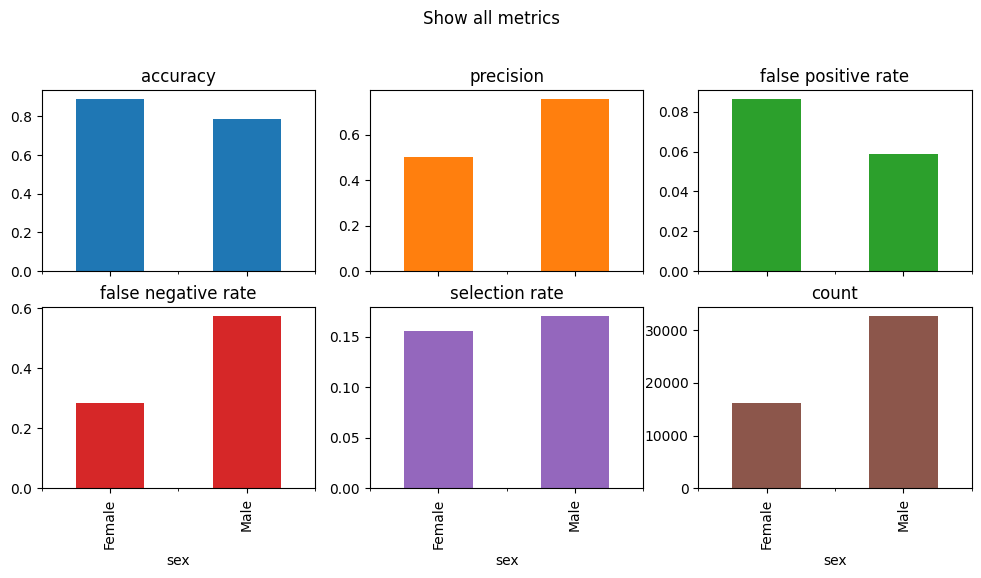

In [11]:
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
    "count": count,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_true, y_pred=y_pred, sensitive_features=sex
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

In [14]:
np.random.seed(0)  # set seed for consistent results with ExponentiatedGradient

constraint = DemographicParity()
classifier = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
mitigator = ExponentiatedGradient(classifier, constraint)
mitigator.fit(X, y_true, sensitive_features=sex)

TypeError: DemographicParity.load_data() missing 1 required keyword-only argument: 'sensitive_features'